In [116]:
import os, re, pickle
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns

from utils.process import categorize, scale, unidecode, tokenize, stem, stop_words
from utils.model import mean_absolute_percentage_error

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score

## TODO

- Test multiple algorithm (Create a model object)
- CountVectorizer
- Aggregate data from AutoPlus

## Import dataset

In [2]:
# See working directory (No need, just for myself)
os.getcwd()

'/home/brendan/Documents/Jupyter/projet_data'

In [3]:
df = pd.read_csv('./data_cars.csv')

In [4]:
df.head(10)

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
0,11220.0,PEUGEOT,308,2014,94341.0 km,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ..."
1,57526.0,BMW,X6,2015,39051.0 km,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M..."
2,80379.0,AUDI,RS6,2014,75381.0 km,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II..."
3,2830.0,FORD,KA,2007,92282.0 km,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis..."
4,12925.0,FIAT,TIPO,2018,10.0 km,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ..."
5,27956.0,BMW,X3,2012,95623.0 km,Diesel,automatique,14/03/2018 à 4h24,"modele: X3 F25, version: (F25) XDRIVE35D 313 S..."
6,16888.0,AUDI,A3,2013,49018.0 km,Diesel,mécanique,16/04/2018 à 21h35,"modele: A3 (2E GENERATION) SPORTBACK, version:..."
7,18188.0,RENAULT,MEGANE,2017,9795.0 km,Diesel,automatique,29/04/2018 à 12h44,"modele: MEGANE 4 ESTATE, version: IV ESTATE 1...."
8,10594.0,FORD,C-MAX,2012,126670.0 km,Diesel,mécanique,22/06/2018 à 5h11,"modele: C-MAX 2, version: II 1.6 TDCI 115 FAP ..."
9,69131.0,MERCEDES,CLASSE C,2015,39439.0 km,Essence,automatique,08/03/2018 à 17h35,"modele: CLASSE C 4 AMG, version: (W205) 63 AMG..."


## Observations

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

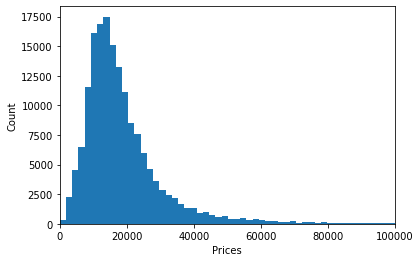

In [6]:
# Price repartition
plt.hist(df["Price"], 800)
plt.xlim(0, 100000)
plt.xlabel('Prices')
plt.ylabel('Count')
plt.show()

Les prix semblent s'agglutiner entre 20000 et 25000 €

Text(0, 0.5, 'Number of cars')

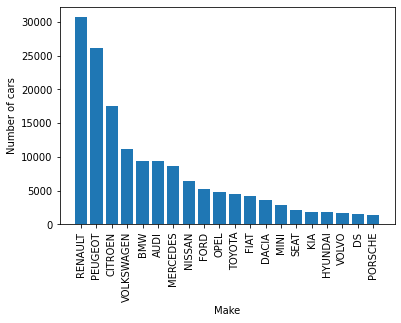

In [7]:
# Make cars counts
counts = df["Make"].value_counts().iloc[0:20]
names = counts.keys().to_numpy()
values = counts.to_numpy()

plt.bar(names, values)
plt.xticks(rotation="vertical")
plt.xlabel("Make")
plt.ylabel("Number of cars")

Le dataset contient beaucoup de voitures Renault, Peugeot et Citroen que de voitures de marque étrangère (BMW, Ford, Mercedes)

## Some data cleaning

### Data types conversions

In [8]:
## Remove kilometers and convert to number
df["Mileage"] = df["Mileage"].str.replace(' km', '').astype("float64")
df.head(5)

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description
0,11220.0,PEUGEOT,308,2014,94341.0,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ..."
1,57526.0,BMW,X6,2015,39051.0,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M..."
2,80379.0,AUDI,RS6,2014,75381.0,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II..."
3,2830.0,FORD,KA,2007,92282.0,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis..."
4,12925.0,FIAT,TIPO,2018,10.0,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ..."


In [9]:
df.dtypes['Mileage']

dtype('float64')

In [10]:
df["Mileage"].isna().sum()

0

In [11]:
# Reduce allocated bytes size for "Model_year" 
df["Model_year"] = df["Model_year"].astype("int16")

## Feature engineering

In [12]:
# Compute age
# df['Posted_on_ts'] = df['Online'].map(lambda date: datetime.strptime(date, '%d/%m/%Y à %Hh%M').timestamp())
# df['Model_year_ts'] = df['Model_year'].map(lambda year: datetime.strptime(str(year), '%Y').timestamp())
# df['Model_age_ts'] = df['Posted_on_ts'] - df['Model_year_ts']
# df.drop(columns=['Posted_on_ts', 'Model_year_ts'])

In [13]:
# We choose 2018 because it was the year the sellers published their offers
df['Model_age'] = df.apply(lambda row: 2018 - row.Model_year, axis = 1)

In [14]:
# See an example of a desc
df['Description'][1]

"modele: X6 F16, version: (F16) XDRIVE30D 258 M SPORT BVA8, puissance_fiscale: 16, portes: 5.0, options: triangle de presignalisation et trousse de premiers secours;volant cuir;pack alu;affichage tête haute;GPS;appel d'urgence intelligent;prise 12v additionnelle;sieges advanced pour conducteur et passager avant;projecteurs antibrouillard;climatisation automatique multi zone;pack suspension adaptative;&quotcarbonschwarz&quot metallise;caméra de recul;finition m sport;jantes alu 20&quot;pack innovation;kit fumeurs;rétroviseurs rabattables électriquement;shadow line brillant;information trafic en temps reel rtti (3ans);aide parking;contrôle de pression des pneus;système audio Harman Kardon;surround view;sièges électrique à mémoire;conciergerie (3 ans);fonctions &quotma bmw a distance&quot;pack safety;airbag passager desactivable via la cle;services connecteddrive (bmw online 3 ans + bmw apps);pack M;planche de bord en cuir;info trafic tmc;lave-phares;ciel de pavillon anthracite;services b

In [15]:
# Getting the number of doors on the car
df['Doors'] = df['Description'].str.extract("portes: ([0-9]+)").astype("float32")

In [16]:
# Getting the horse power of a car
df['Fisc_hp'] = df['Description'].str.extract("puissance_fiscale: ([0-9]+)").astype("float32")

In [17]:
df.head()

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description,Model_age,Doors,Fisc_hp
0,11220.0,PEUGEOT,308,2014,94341.0,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ...",4,5.0,4.0
1,57526.0,BMW,X6,2015,39051.0,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M...",3,5.0,16.0
2,80379.0,AUDI,RS6,2014,75381.0,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II...",4,5.0,47.0
3,2830.0,FORD,KA,2007,92282.0,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis...",11,3.0,5.0
4,12925.0,FIAT,TIPO,2018,10.0,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ...",0,5.0,5.0


### Language processing

In [18]:
# Getting the options of the car inside the description
df['Options'] = df['Description'].str.extract("options: (.+)")

In [19]:
# Do natural language processing (see process.py)
options_words = df["Options"].pipe(unidecode).pipe(tokenize).pipe(stop_words).pipe(stem).str.join(' ')
# THIS TAKE A LOTS OF TIME :O

In [20]:
options_words.head(5)

0    banquet arrier plac vol cuir cach bagag airbag...
1    triangl presignalis trouss premi secour vol cu...
2    banquet arrier plac ecran tactil temoin boucla...
3    direct assiste jant alu retroviseur electr deg...
4    vol alu cuir bluetooth inclut musiqu streaming...
Name: Options, dtype: object

In [21]:
vectorizer = CountVectorizer(min_df=200)
options_counts = vectorizer.fit_transform(options_words).toarray()
options_counts

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [22]:
pca = PCA(n_components=100)
options_components = pca.fit_transform(options_counts)
options_components

array([[ 4.64846452e+00, -3.45576218e+00,  1.93096300e-01, ...,
        -8.95876878e-02, -3.12500714e-01,  1.77824465e-02],
       [-4.99394142e+00,  2.81688178e+00,  3.86295593e+00, ...,
         1.13840325e-01,  4.28785162e-01,  1.63107678e-01],
       [ 2.00016207e+01,  5.84303354e+00,  3.03190157e+00, ...,
        -5.68934319e-01, -1.20200854e+00, -9.61229696e-01],
       ...,
       [ 5.13706482e+00, -1.07864991e+00, -5.51660216e+00, ...,
        -3.03597213e-02, -2.28576525e-01, -3.14116042e-01],
       [ 1.52417331e+00,  2.27503222e+00, -1.20608097e+00, ...,
         1.51300873e-04, -7.99023651e-02, -4.80607567e-01],
       [-7.44879224e+00, -5.08854795e-01,  1.17760377e+00, ...,
        -5.69624802e-02, -1.20983487e-01, -2.83120639e-02]])

In [23]:
options_df = pd.DataFrame(options_components).add_prefix('Option_')
options_df

,Option_0,Option_1,Option_2,Option_3,Option_4,Option_5,Option_6,Option_7,Option_8,Option_9,...,Option_90,Option_91,Option_92,Option_93,Option_94,Option_95,Option_96,Option_97,Option_98,Option_99
0,4.648465,-3.455762,0.193096,-0.726573,-0.658957,2.897323,-0.960002,0.552745,-2.202490,-0.605950,...,-0.018547,0.584936,0.005296,0.197025,0.015309,0.172090,-0.292031,-0.089588,-0.312501,0.017782
1,-4.993941,2.816882,3.862956,-0.612920,-0.300094,-0.179467,2.613754,2.428985,-1.759859,6.975492,...,-0.063677,-0.296542,0.187477,-0.646449,0.306251,-0.250319,0.075424,0.113840,0.428785,0.163108
2,20.001621,5.843034,3.031902,-3.752820,-1.111132,-0.867836,0.676329,5.556755,0.275930,-0.313867,...,-0.359486,-0.547292,-0.017460,-0.324130,-0.677802,-0.712600,-0.845097,-0.568934,-1.202009,-0.961230
3,-8.247456,-1.081561,0.125195,-0.470813,-0.393987,-0.236663,-1.399465,1.068658,-0.065980,-0.802136,...,-0.098180,0.206940,0.124715,-0.426324,0.267796,0.061592,-0.161896,0.032925,-0.039696,-0.020430
4,-6.459532,2.029783,-1.405209,1.820419,-2.554434,4.705992,-1.087476,0.113895,0.155698,0.476962,...,-0.437531,0.257902,-0.172516,0.075619,-0.302328,0.145358,-0.429446,0.067358,-0.452227,0.146430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166690,10.315502,-2.040633,-0.012238,0.293045,-2.642852,-2.107336,0.447643,0.206874,-0.410036,0.059030,...,0.023454,0.143367,-0.275207,0.356946,-0.684099,0.010072,-0.560521,-0.367693,-0.425975,0.402139
166691,1.932622,7.283648,-2.407363,4.977298,-2.608513,1.380418,0.628309,-3.556804,-0.494880,0.189657,...,0.419856,-0.119824,0.086067,-0.283975,-0.284383,0.090366,0.001561,-0.085121,0.268615,0.055476
166692,5.137065,-1.078650,-5.516602,0.195558,1.181250,0.411267,1.524293,0.621377,1.382129,0.878668,...,0.100736,0.036424,-0.145927,0.029900,0.446462,0.005609,-0.059245,-0.030360,-0.228577,-0.314116
166693,1.524173,2.275032,-1.206081,-1.356212,2.327248,0.249826,-4.148883,-0.566390,0.734639,-0.444529,...,-0.350207,0.828476,1.154709,0.419930,-1.070912,-0.599315,0.356964,0.000151,-0.079902,-0.480608


In [24]:
df = pd.concat([df, options_df], axis=1)
df

,Price,Make,Model,Model_year,Mileage,Fuel,Gearbox,Online,Description,Model_age,...,Option_90,Option_91,Option_92,Option_93,Option_94,Option_95,Option_96,Option_97,Option_98,Option_99
0,11220.0,PEUGEOT,308,2014,94341.0,Diesel,mécanique,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ...",4,...,-0.018547,0.584936,0.005296,0.197025,0.015309,0.172090,-0.292031,-0.089588,-0.312501,0.017782
1,57526.0,BMW,X6,2015,39051.0,Diesel,automatique,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M...",3,...,-0.063677,-0.296542,0.187477,-0.646449,0.306251,-0.250319,0.075424,0.113840,0.428785,0.163108
2,80379.0,AUDI,RS6,2014,75381.0,Essence,automatique,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II...",4,...,-0.359486,-0.547292,-0.017460,-0.324130,-0.677802,-0.712600,-0.845097,-0.568934,-1.202009,-0.961230
3,2830.0,FORD,KA,2007,92282.0,Essence,mécanique,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis...",11,...,-0.098180,0.206940,0.124715,-0.426324,0.267796,0.061592,-0.161896,0.032925,-0.039696,-0.020430
4,12925.0,FIAT,TIPO,2018,10.0,Essence,mécanique,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ...",0,...,-0.437531,0.257902,-0.172516,0.075619,-0.302328,0.145358,-0.429446,0.067358,-0.452227,0.146430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166690,20990.0,AUDI,A4,2014,65885.0,Diesel,automatique,06/07/2018 à 5h44,"modele: A4 (4E GENERATION) AVANT, version: IV ...",4,...,0.023454,0.143367,-0.275207,0.356946,-0.684099,0.010072,-0.560521,-0.367693,-0.425975,0.402139
166691,12056.0,VOLKSWAGEN,GOLF,2015,186000.0,Diesel,automatique,01/06/2018 à 15h22,"modele: GOLF 7, version: VII 2.0 TDI 150 BLUEM...",3,...,0.419856,-0.119824,0.086067,-0.283975,-0.284383,0.090366,0.001561,-0.085121,0.268615,0.055476
166692,13423.0,FORD,FIESTA,2016,8784.0,Essence,mécanique,26/07/2018 à 18h57,"modele: FIESTA 5, version: V (2) 1.0 ECOBOOST ...",2,...,0.100736,0.036424,-0.145927,0.029900,0.446462,0.005609,-0.059245,-0.030360,-0.228577,-0.314116
166693,11918.0,SKODA,OCTAVIA,2013,111339.0,Diesel,automatique,30/05/2018 à 17h55,"modele: OCTAVIA 3, version: III 2.0 TDI 150 GR...",5,...,-0.350207,0.828476,1.154709,0.419930,-1.070912,-0.599315,0.356964,0.000151,-0.079902,-0.480608


## Data checks (null or NaN)

In [25]:
# Check for null values
df.isnull().sum()

Price         0
Make          0
Model         0
Model_year    0
Mileage       0
             ..
Option_95     0
Option_96     0
Option_97     0
Option_98     0
Option_99     0
Length: 113, dtype: int64

In [26]:
# Check for invalid numbers
df.isna().sum()

Price         0
Make          0
Model         0
Model_year    0
Mileage       0
             ..
Option_95     0
Option_96     0
Option_97     0
Option_98     0
Option_99     0
Length: 113, dtype: int64

In [27]:
# Find empty strings
np.where(df.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

## Removing outliers

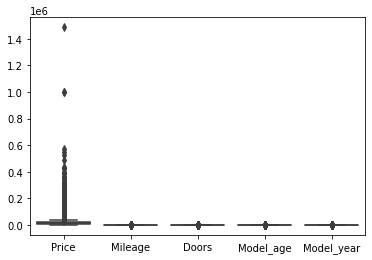

In [62]:
sns.boxplot(data=df[['Price', 'Mileage', 'Doors', 'Model_age', 'Model_year']])

#### Check of Model_year, Fisc_hp, Doors outliers

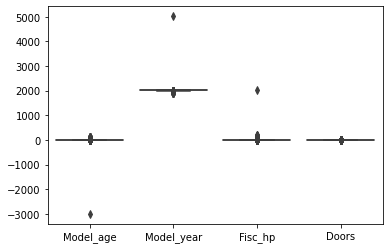

In [29]:
sns.boxplot(data=df[['Model_age','Model_year','Fisc_hp','Doors']])

In [30]:
df = df.drop(df[df.Model_year > 3000].index)

In [31]:
df = df.drop(df[df.Fisc_hp > 1000].index)

In [32]:
df = df.drop(df[df.Fisc_hp <= 0].index)

#### Check for Price outliers

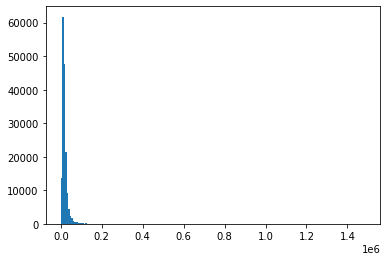

In [33]:
plt.hist(df['Price'], bins=200, range=(df['Price'].min(), df['Price'].max()))
plt.show()

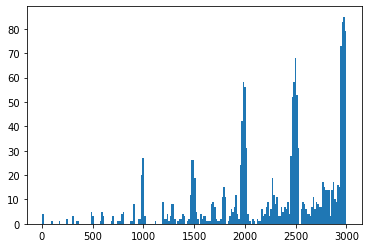

In [34]:
plt.hist(df['Price'], bins=200, range=(df['Price'].min(), 3000))
plt.show()

In [35]:
# Cheap cars sold lower than 150 euros are rare
df = df.drop(df[df.Price <= 400].index)

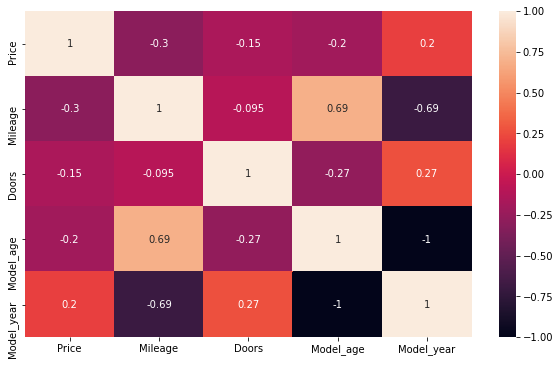

In [36]:
plt.figure(figsize=(10,6))
sns.heatmap(df[['Price', 'Mileage', 'Doors', 'Model_age', 'Model_year']].corr(), annot=True)

## Data normalization

In [37]:
df[['Model_age', 'Mileage']] = scale(df[['Model_age', 'Mileage']])

## Hot encoding

In [38]:
# List categorical columns
df["Fuel"].unique()

array(['Diesel', 'Essence', 'Hybride essence électrique', 'Electrique',
       'Hybride diesel électrique', 'Bicarburation essence GPL',
       'Bicarburation essence bioéthanol'], dtype=object)

In [39]:
# List categorical columns for Gearbox
df["Gearbox"].unique()

array(['mécanique', 'automatique'], dtype=object)

In [40]:
df = pd.get_dummies(df, columns=["Gearbox"], drop_first=True)

In [41]:
df = pd.get_dummies(df, columns=["Fuel"])
df

,Price,Make,Model,Model_year,Mileage,Online,Description,Model_age,Doors,Fisc_hp,...,Option_98,Option_99,Gearbox_mécanique,Fuel_Bicarburation essence GPL,Fuel_Bicarburation essence bioéthanol,Fuel_Diesel,Fuel_Electrique,Fuel_Essence,Fuel_Hybride diesel électrique,Fuel_Hybride essence électrique
0,11220.0,PEUGEOT,308,2014,0.981822,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ...",0.154899,5.0,4.0,...,-0.312501,0.017782,1,0,0,1,0,0,0,0
1,57526.0,BMW,X6,2015,-0.165291,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M...",-0.108871,5.0,16.0,...,0.428785,0.163108,0,0,0,1,0,0,0,0
2,80379.0,AUDI,RS6,2014,0.588455,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II...",0.154899,5.0,47.0,...,-1.202009,-0.961230,0,0,0,0,0,1,0,0
3,2830.0,FORD,KA,2007,0.939104,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis...",2.001288,3.0,5.0,...,-0.039696,-0.020430,1,0,0,0,0,1,0,0
4,12925.0,FIAT,TIPO,2018,-0.975282,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ...",-0.900181,5.0,5.0,...,-0.452227,0.146430,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166690,20990.0,AUDI,A4,2014,0.391440,06/07/2018 à 5h44,"modele: A4 (4E GENERATION) AVANT, version: IV ...",0.154899,5.0,10.0,...,-0.425975,0.402139,0,0,0,1,0,0,0,0
166691,12056.0,VOLKSWAGEN,GOLF,2015,2.883490,01/06/2018 à 15h22,"modele: GOLF 7, version: VII 2.0 TDI 150 BLUEM...",-0.108871,5.0,8.0,...,0.268615,0.055476,0,0,0,1,0,0,0,0
166692,13423.0,FORD,FIESTA,2016,-0.793246,26/07/2018 à 18h57,"modele: FIESTA 5, version: V (2) 1.0 ECOBOOST ...",-0.372641,5.0,5.0,...,-0.228577,-0.314116,1,0,0,0,0,1,0,0
166693,11918.0,SKODA,OCTAVIA,2013,1.334483,30/05/2018 à 17h55,"modele: OCTAVIA 3, version: III 2.0 TDI 150 GR...",0.418668,5.0,8.0,...,-0.079902,-0.480608,0,0,0,1,0,0,0,0


In [42]:
df.head(5)

,Price,Make,Model,Model_year,Mileage,Online,Description,Model_age,Doors,Fisc_hp,...,Option_98,Option_99,Gearbox_mécanique,Fuel_Bicarburation essence GPL,Fuel_Bicarburation essence bioéthanol,Fuel_Diesel,Fuel_Electrique,Fuel_Essence,Fuel_Hybride diesel électrique,Fuel_Hybride essence électrique
0,11220.0,PEUGEOT,308,2014,0.981822,06/07/2018 à 3h47,"modele: 308 (2E GENERATION), version: 1.6 HDI ...",0.154899,5.0,4.0,...,-0.312501,0.017782,1,0,0,1,0,0,0,0
1,57526.0,BMW,X6,2015,-0.165291,03/04/2018 à 16h41,"modele: X6 F16, version: (F16) XDRIVE30D 258 M...",-0.108871,5.0,16.0,...,0.428785,0.163108,0,0,0,1,0,0,0,0
2,80379.0,AUDI,RS6,2014,0.588455,30/07/2018 à 1h55,"modele: RS6 (3E GENERATION) AVANT, version: II...",0.154899,5.0,47.0,...,-1.202009,-0.961230,0,0,0,0,0,1,0,0
3,2830.0,FORD,KA,2007,0.939104,09/07/2018 à 14h12,"modele: KA, version: 1.3 70 FUN, puissance_fis...",2.001288,3.0,5.0,...,-0.039696,-0.020430,1,0,0,0,0,1,0,0
4,12925.0,FIAT,TIPO,2018,-0.975282,19/05/2018 à 3h52,"modele: TIPO 2 SW, version: II SW 1.4 95 POP, ...",-0.900181,5.0,5.0,...,-0.452227,0.146430,1,0,0,0,0,1,0,0


In [43]:
np.sort(df['Make'].unique())

array(['ABARTH', 'AC', 'AIXAM', 'ALFA ROMEO', 'ALPINA', 'ALPINE',
       'ASTON MARTIN', 'AUDI', 'AUSTIN', 'AUSTIN HEALEY', 'AUTOBIANCHI',
       'BELLIER', 'BENTLEY', 'BMW', 'BMW-ALPINA', 'BOLLORE', 'BUGATTI',
       'BURBY S', 'CADILLAC', 'CATERHAM', 'CHATENET', 'CHEVROLET',
       'CHRYSLER', 'CITROEN', 'DACIA', 'DAEWOO', 'DAIHATSU', 'DANGEL',
       'DODGE', 'DONKERVOORT', 'DS', 'FERRARI', 'FIAT', 'FISKER', 'FORD',
       'GRECAV', 'HONDA', 'HUMMER', 'HYUNDAI', 'INFINITI', 'INNOCENTI',
       'INTERMECCANICA', 'JAGUAR', 'JEEP', 'JIAYUAN', 'KIA', 'LADA',
       'LAMBORGHINI', 'LANCIA', 'LAND ROVER', 'LEXUS', 'LIGIER', 'LOTUS',
       'MASERATI', 'MATRA', 'MAZDA', 'MCLAREN', 'MERCEDES',
       'MERCEDES-AMG', 'MG', 'MIA ELECTRIC', 'MICROCAR', 'MINI',
       'MITSUBISHI', 'MORGAN', 'MPM MOTORS', 'NISSAN', 'OLDSMOBILE',
       'OPEL', 'PACKARD', 'PEUGEOT', 'PORSCHE', 'RENAULT', 'RILEY',
       'ROLLS ROYCE', 'ROVER', 'SAAB', 'SEAT', 'SECMA', 'SHELBY', 'SIMCA',
       'SKODA', 'SMART', 

In [44]:
# Transform makes to ordinal numbers
df['Make'] = categorize(df['Make'])
df['Make'] = df['Make'].astype('category')
df['Make'].head(5)

0    0
1    1
2    2
3    3
4    4
Name: Make, dtype: category
Categories (92, int64): [0, 1, 2, 3, ..., 88, 89, 90, 91]

In [45]:
np.sort(df['Model'].unique()[0:60])

array(['2008', '208', '3008', '308', '407', '500', '500 X', '5008', 'A3',
       'A4', 'A5', 'ARONA', 'ASTRA', 'AURIS', 'C-MAX', 'C3', 'C4',
       'C4 PICASSO', 'C5', 'CLASSE A', 'CLASSE B', 'CLASSE C', 'CLASSE R',
       'CLIO', 'DS3', 'DUSTER', 'GOLF', 'GRAND C-MAX',
       'GRAND C4 SPACETOURER', 'GRAND SCENIC', 'I20', 'I30', 'IBIZA',
       'KA', 'KADJAR', 'KOLEOS', 'KUGA', 'MACAN', 'MEGANE', 'MINI',
       'MONDEO', 'PASSAT', 'POLO', 'QASHQAI', 'RS6', 'SANDERO', 'SCENIC',
       'SERIE 1', 'SERIE 2', 'SERIE 3 GT', 'SERIE 5', 'SL', 'TALISMAN',
       'TIGUAN', 'TIPO', 'TOURAN', 'TWINGO', 'X3', 'X6', 'XKR'],
      dtype=object)

In [46]:
# Transform models to ordinal numbers
df['Model'] = categorize(df['Model'])
df['Model'] = df['Model'].astype('category')
df['Model'].head(5)

0    0
1    1
2    2
3    3
4    4
Name: Model, dtype: category
Categories (837, int64): [0, 1, 2, 3, ..., 833, 834, 835, 836]

### Check for valid types

In [47]:
df.dtypes

Price                               float64
Make                               category
Model                              category
Model_year                            int16
Mileage                             float64
                                     ...   
Fuel_Diesel                           uint8
Fuel_Electrique                       uint8
Fuel_Essence                          uint8
Fuel_Hybride diesel électrique        uint8
Fuel_Hybride essence électrique       uint8
Length: 119, dtype: object

## Feature selection

In [48]:
X = df
y = df["Price"]

X = X.drop([
        'Price', 
        'Online',
        'Model_year', 
        'Doors',
        'Description',
        'Options',
        'Fuel_Bicarburation essence GNV'
       ], axis=1, errors='ignore')

X.columns

Index(['Make', 'Model', 'Mileage', 'Model_age', 'Fisc_hp', 'Option_0',
       'Option_1', 'Option_2', 'Option_3', 'Option_4',
       ...
       'Option_98', 'Option_99', 'Gearbox_mécanique',
       'Fuel_Bicarburation essence GPL',
       'Fuel_Bicarburation essence bioéthanol', 'Fuel_Diesel',
       'Fuel_Electrique', 'Fuel_Essence', 'Fuel_Hybride diesel électrique',
       'Fuel_Hybride essence électrique'],
      dtype='object', length=113)

## Split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

In [50]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((99408, 113), (66273, 113), (99408,), (66273,))

In [51]:
X_train.head(5)

,Make,Model,Mileage,Model_age,Fisc_hp,Option_0,Option_1,Option_2,Option_3,Option_4,...,Option_98,Option_99,Gearbox_mécanique,Fuel_Bicarburation essence GPL,Fuel_Bicarburation essence bioéthanol,Fuel_Diesel,Fuel_Electrique,Fuel_Essence,Fuel_Hybride diesel électrique,Fuel_Hybride essence électrique
30525,1,78,-0.348219,-0.372641,34.0,-8.253399,0.719644,0.489952,-2.325066,-0.380002,...,-0.471927,0.299932,0,0,0,0,0,1,0,0
100906,1,59,0.741300,0.154899,20.0,-3.479326,1.813317,-0.494345,2.008649,0.758960,...,-0.380210,0.032053,0,0,0,1,0,0,0,0
71646,22,155,-0.890509,-0.636411,5.0,5.950769,-4.416503,0.959482,3.726106,-0.859325,...,-0.059482,0.364904,0,0,0,0,0,1,0,0
2403,5,25,1.956339,2.001288,7.0,-5.056496,0.629435,-1.244241,-0.665262,1.243723,...,0.375376,-0.085272,1,0,0,0,0,1,0,0
134355,8,11,-0.975282,-0.900181,5.0,-4.865156,1.176965,3.360297,-1.986227,-1.658989,...,0.101774,0.680989,1,0,0,0,0,1,0,0


In [52]:
y_train.head(5)

30525     72092.0
100906    34024.0
71646     16309.0
2403       3950.0
134355    26212.0
Name: Price, dtype: float64

## Train / Predict

In [82]:
lreg = RandomForestRegressor(max_depth=7, random_state=0)

In [83]:
lreg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [84]:
y_pred = lreg.predict(X_test)

In [118]:
mean_absolute_percentage_error(y_test, y_pred)

20.310993186542653

In [86]:
r2_score(y_test, y_pred)

0.6864739354592959

In [87]:
y_pred

array([17451.19007528, 10797.16668559,  8901.90664649, ...,
       15035.67734257, 17965.11896989, 28444.09380208])

In [88]:
y_test.to_numpy()

array([19781., 16466.,  8070., ..., 15569., 17766., 28123.])

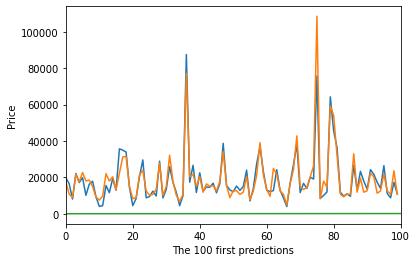

In [89]:
plt.plot(y_test.to_numpy()[0:100])
plt.plot(y_pred[0:100])
plt.xlim([0, 100])
plt.xlabel('The 100 first predictions')
plt.ylabel('Price')
plt.plot([-100, 100], [-100, 100])

In [115]:
# Save model
pickle.dump(lreg, open('model.sav', 'wb'))